In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import fastai
import math
from functools import partial

import glob
import os
import pandas as pd
from common.bio.constants import *
from tqdm import tqdm

from fastprogress.fastprogress import NBProgressBar
from fastai.basic_train import loss_batch
from fastai.basic_data import to_device
from fastai.torch_core import to_np
import sys
sys.path.append("..")
from utils import *

c:\users\donatas\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\donatas\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
ROOT = "../../data/protein/classification/sample_512/"
DATA_PATH = ROOT+"1_kmers"
MODEL_PATH = "../../weights/protein/classification/sample_512/test"
SEQUENCE_LENGTH=512
VOCAB_SIZE=20
BERT_CONFIG_FILE = "../../../bert/config/bert_config_file.json"
BERT_WEIGHTS = "../../../bert_pytorch/weights/tpu"

In [21]:
# ROOT = "../../data/protein/embedding/"
# file_path = ROOT + "data_sources/unreviewed.gz"
# data = pd.read_csv(file_path, sep='\t', header=(0), skipinitialspace=True).drop("Entry", axis=1)
# data = data.rename(columns={"Sequence" :"sequence"})
# data.sequence = data.sequence.str.strip()

# for amino_acid in ['B','O','U','X','Z' ]:
#     data = data[~data["sequence"].str.contains(amino_acid)]

# data["sequence"] = data.sequence.apply(lambda x: [ AMINO_ACID_TO_ID[c] for c in x])
# data.values.shape
# np.save("../../data/protein/classification/sample_512/1_kmers/unreviewed/data.npy",data.values)

In [3]:
epochs = 1
num_workers = 8 # On cloud 8
batch_size = 64

## Input

In [4]:
class BertDataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, path_or_data, seq_length, vocab_size=20, records_to_test = 1000000):
        #self.data = np.load(path)[:records_to_test]
        if isinstance(path_or_data, str):
            self.data = np.load(path_or_data)[2]
        else: 
            self.data = path_or_data
        self.seq_length = seq_length
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
#         seq = np.asarray(row[-1])
        seq = row
        length = (0 == seq).argmax(axis=0) if (0 in seq) else len(seq)
        mask = np.ones(length)
        masked_seq = np.copy(seq)        
        indicies = np.sort(np.random.randint(0, length-1, 20))
        np.put(masked_seq, indicies, 21)
#         seq, mask, masked_seq = self.pad([seq, mask, masked_seq], self.seq_length-length)
        mask = self.pad([mask], self.seq_length-length)[0]
        label = np.take(seq, indicies)
        output = self.to_int64([masked_seq, mask, indicies, seq, label])
        return output[0:4], output[4]
    
    def pad(self, items_to_pad, pad_width):
        for i in range(len(items_to_pad)):
            items_to_pad[i] = np.pad(items_to_pad[i], mode="constant", pad_width=(0,pad_width))        
        return items_to_pad
        
    def to_int64(self, items_to_convert):
        for i in range(len(items_to_convert)):
            items_to_convert[i] = np.int64(items_to_convert[i])
        return items_to_convert
        

In [75]:
def validate_ds(test_ds):
    (masked_seq, mask, indicies, seq), label = test_ds.__getitem__(1)
    assert (0 == masked_seq).argmax(axis=0) == (0 == mask).argmax(axis=0)
    assert len(masked_seq) == 512
    assert len(mask) == 512
    assert len(indicies) == 20
    assert len(seq) == 512
    assert len(label) == 20

## Model

In [7]:
from pytorch_pretrained_bert.modeling import *
class BertTest(nn.Module):
    def __init__(self, config):
        super(BertTest, self).__init__()
        self.bert = BertForPreTraining(config)
        
    def forward(self, masked_seq, attention_mask, indicies, masked_lm_labels, token_ids=None):
        prediction_scores, _ = self.bert(masked_seq, 
                                         token_type_ids=token_ids, 
                                         attention_mask=attention_mask, 
                                         masked_lm_labels=masked_lm_labels)
        return prediction_scores

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [8]:
from pytorch_pretrained_bert.modeling import BertConfig
bert_config = BertConfig.from_json_file(BERT_CONFIG_FILE)
bert_test = BertTest(bert_config)
bert_test.bert.load_state_dict(torch.load(BERT_WEIGHTS, map_location='cpu'))
bert_test.to('cuda')

BertTest(
  (bert): BertForPreTraining(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(22, 512)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(16, 512)
        (LayerNorm): BertLayerNorm()
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=512, out_features=512, bias=True)
                (key): Linear(in_features=512, out_features=512, bias=True)
                (value): Linear(in_features=512, out_features=512, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=512, out_features=512, bias=True)
                (LayerNorm): BertLayerNorm()
                (dropout): Dropout(p=0.1)
            

In [9]:
bert_test.bert.bert.embeddings.word_embeddings.weight[0][:10]

tensor([-0.0187,  0.0076, -0.1088,  0.0023, -0.0215, -0.0242, -0.0327, -0.0327,
        -0.0119, -0.0202], device='cuda:0', grad_fn=<SliceBackward>)

In [10]:
for n, p in bert_test.bert.named_parameters():
    if p.requires_grad: 
        p.requires_grad=False
sum(p.numel() for p in bert_test.parameters() if p.requires_grad)

0

In [161]:
# test_ds = BertDataSet("../../../bert/weights/eval_full/20181217_073706_412768.npy", SEQUENCE_LENGTH)
seq = (np.load("../../../bert/weights/eval_full/20181217_073706_412768.npy")[2][165])
seqs = np.repeat(np.expand_dims(seq, axis=0), 16, axis=0)
test_ds = BertDataSet(seqs, SEQUENCE_LENGTH)
validate_ds(test_ds)
dl = DataLoader(test_ds, batch_size=16, shuffle=False)

In [162]:
def accuracy(input, targs):
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean(dim=1)

In [163]:
model = bert_test
#loss_func = nn.CrossEntropyLoss(reduction='none')
loss_func = bert_loss
model.eval()
xbs, ybs, preds, loss, acc = [None, None, None, None], None, None, None, None
with torch.no_grad():
    val_losses, val_acc, steps = [],[], 0
    for xb,yb in NBProgressBar(dl):
        xb, yb = to_device((xb, yb), torch.device('cuda'))
        out = model(*xb)
        for i in range(len(xb)):
            xbs[i] = append(xbs[i], xb[i])
        ybs = append(ybs, yb)
        pred = torch.nn.functional.log_softmax(batched_index_select(out,1, xb[2]), dim=-1).reshape([-1, 20, 22])
        preds = append(preds, pred)
        loss = append(loss, loss_func(pred, yb, bert_config.vocab_size).mean(dim=1))
        acc = append(acc, accuracy(pred, yb))
        steps = steps + 1
        if steps == 100:
            break
             
loss.mean(), acc.mean()

(tensor(2.9027, device='cuda:0'), tensor(0.0969, device='cuda:0'))

In [164]:
accuracies = to_np(acc)
losses = to_np(loss)
predictions = to_np(preds.transpose(1,2))

In [165]:
masked_seq, mask, indicies, seq = [to_np(x) for x in xbs]

In [166]:
labels = to_np(ybs)

## Accuracy

In [167]:
unique, counts=np.unique(accuracies, return_counts=True)
dict(zip(unique, counts))

{0.0: 2, 0.05: 3, 0.1: 6, 0.15: 4, 0.2: 1}

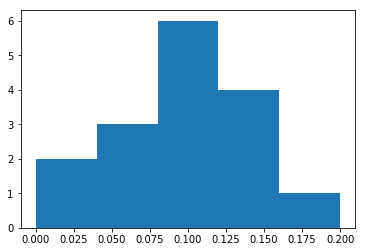

In [168]:
import matplotlib.pyplot as plt
plt.hist(accuracies, bins='auto')
plt.show()

## Losses

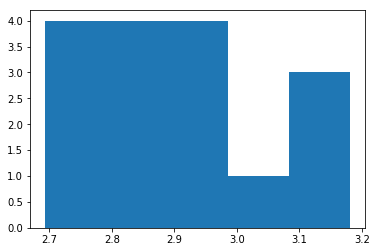

In [169]:
import matplotlib.pyplot as plt
plt.hist(losses, bins='auto')
plt.show()

## Accuracy per amino acid

In [170]:
list(zip(np.unique(labels, return_counts=True)))

[(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20], dtype=int64),),
 (array([12,  4, 22, 26, 15, 31,  6, 32, 17, 28, 14,  6, 23, 25, 26, 17,  5, 11], dtype=int64),)]

In [171]:
unique_g, counts_g = np.unique(predictions.argmax(axis=2), return_counts=True)
unique_t, counts_t = np.unique(labels, return_counts=True)
dict(zip(unique_g, counts_g)), dict(zip(unique_t, counts_t))

({0: 41,
  1: 23,
  2: 12,
  3: 15,
  4: 23,
  5: 16,
  6: 10,
  7: 19,
  8: 14,
  9: 9,
  10: 6,
  11: 10,
  12: 11,
  13: 17,
  14: 13,
  15: 14,
  16: 19,
  17: 26,
  18: 33,
  19: 21},
 {1: 12,
  2: 4,
  3: 22,
  4: 26,
  5: 15,
  6: 31,
  7: 6,
  8: 32,
  9: 17,
  10: 28,
  11: 14,
  12: 6,
  13: 23,
  15: 25,
  16: 26,
  17: 17,
  18: 5,
  20: 11})

In [172]:
predictions.shape, labels.shape

((16, 22, 20), (16, 20))

In [173]:
data = np.column_stack((predictions.argmax(axis=1).flatten(),labels.flatten(),np.repeat(accuracies, 20, axis=0)))
amino_acids = pd.DataFrame(data, columns=["Guess", "Actual", "Accuracy"])
amino_acids.shape

(320, 3)

In [174]:
amino_acids["Correct"] = amino_acids["Guess"] == amino_acids["Actual"]

In [175]:
pd.concat([amino_acids.groupby(by="Guess").agg({"Correct":['mean','count'], "Accuracy": ["mean"]}), 
           amino_acids.groupby(by="Actual").agg({"Correct":['mean','count'], "Accuracy": ["mean"]})]
          ,axis=1)

Correct         Accuracy   Correct        Accuracy
          mean  count      mean      mean count      mean
1.0   0.000000   13.0  0.103846  0.000000    12  0.100000
2.0   0.000000   12.0  0.100000  0.000000     4  0.100000
3.0   0.000000    4.0  0.037500  0.000000    22  0.097727
4.0   0.043478   46.0  0.091304  0.076923    26  0.101923
5.0   0.000000    1.0  0.150000  0.000000    15  0.103333
6.0   0.090909   22.0  0.118182  0.064516    31  0.087097
7.0        NaN    NaN       NaN  0.000000     6  0.116667
8.0   0.400000    5.0  0.140000  0.062500    32  0.079688
9.0   0.066667   15.0  0.076667  0.058824    17  0.100000
10.0  0.113924  158.0  0.095253  0.642857    28  0.114286
11.0  1.000000    6.0  0.133333  0.428571    14  0.117857
12.0       NaN    NaN       NaN  0.000000     6  0.116667
13.0  0.000000    2.0  0.150000  0.000000    23  0.089130
15.0  0.000000   12.0  0.075000  0.000000    25  0.106000
16.0  0.000000   13.0  0.096154  0.000000    26  0.082692
17.0  0.000000    4.0  0.162500  0.000000    17  0.094118
18.0  0.000000    7.0  0.078571  0.000000     5  0.120000
20.0       NaN    NaN       NaN  0.000000    11  0.072727

In [176]:
amino_acids['Correct'].sum()

31

In [177]:
df_top_freq = amino_acids[~amino_acids['Correct']].groupby(["Guess", "Actual"])['Correct'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False).head(20).reset_index()
df_top_freq

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Guess,Actual,code_count
0,10.0,8.0,18
1,10.0,16.0,18
2,10.0,13.0,13
3,10.0,4.0,12
4,10.0,6.0,12
5,10.0,3.0,11
6,2.0,15.0,11
7,10.0,17.0,10
8,6.0,5.0,9
9,4.0,9.0,8


In [178]:
df_top_freq = amino_acids[(~amino_acids['Correct']) & (amino_acids['Accuracy'] >= 0.5)].groupby(["Guess", "Actual"])['Correct'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False).head(11).reset_index()
df_top_freq

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,index,code_count


In [180]:
df_top_freq = amino_acids[(~amino_acids['Correct']) & (amino_acids['Accuracy'] < 0.2)].groupby(["Guess", "Actual"])['Correct'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False).head(11).reset_index()
df_top_freq

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Guess,Actual,code_count
0,10.0,8.0,17
1,10.0,16.0,16
2,10.0,13.0,13
3,10.0,6.0,12
4,10.0,4.0,12
5,10.0,3.0,10
6,2.0,15.0,10
7,6.0,5.0,9
8,10.0,17.0,9
9,10.0,1.0,8


In [181]:
df_top_freq = amino_acids[(amino_acids['Correct']) & (amino_acids['Accuracy'] < 1.5)].groupby(["Guess", "Actual"])['Correct'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False).head(20).reset_index()
df_top_freq

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Guess,Actual,code_count
0,10.0,10.0,18
1,11.0,11.0,6
2,4.0,4.0,2
3,6.0,6.0,2
4,8.0,8.0,2
5,9.0,9.0,1


## Analysis

In [182]:
worst = np.argmin(accuracies)
best = np.argmax(accuracies)
accuracies[worst], accuracies[best]

(0.0, 0.2)

In [214]:
def get_table(index):
    print("Accuracy:{} | Loss: {}".format(accuracies[index], losses[index]))
    in_seq, original = "", ""
    for i, a in enumerate(masked_seq[index]):
        if a == 0:
            break
        if a == 21:
            position = np.argwhere(indicies[index] == i)[0][0]
            in_seq = in_seq + "("+ID_TO_AMINO_ACID[predictions[index].argmax(axis=0)[position]]+")"
            original = original + "("+ID_TO_AMINO_ACID[seq[index][i]]+")"
        else:
            in_seq = in_seq + ID_TO_AMINO_ACID[a]
            original = original + ID_TO_AMINO_ACID[seq[index][i]]

    print(in_seq) 
    print(original)
    data = list(zip(labels[index], predictions[index].argmax(axis=0), 
                    np.transpose(predictions[index].argsort(axis=0))[:, ::-1],
                    np.sort(np.transpose(predictions[index]))[:, ::-1]))
    df = pd.DataFrame(data, columns=['Correct', 'Guess', 'Other guess', 'Probs'], index=indicies[index]) 
    df = df[~df.index.duplicated(keep='first')]
    return df.sort_index()

In [200]:
len(np.where(accuracies <0.2)[0])

15

In [201]:
len(np.where(accuracies >0.7)[0])

0

In [202]:
arr = seq[np.where(accuracies <0.2)]
(arr ==0).argmax(axis=1).mean()

64.0

In [203]:
arr = seq[np.where(accuracies >0.8)]
(arr ==0).argmax(axis=1).mean()

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [204]:
losses[np.where(accuracies <0.2)].mean()

2.9129055

In [205]:
losses[np.where(accuracies >0.8)].mean()

c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
c:\users\donatas\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


nan

In [206]:
losses

array([2.722157, 2.693942, 2.777917, 2.922022, 2.749659, 2.797064, 3.086044, 3.123373, 2.898413, 3.072436, 2.874888,
       2.796643, 3.180427, 2.979404, 2.857519, 2.911334], dtype=float32)

In [207]:
losses.argsort(axis=0)[:10], losses.argsort(axis=0)[-10:]

(array([ 1,  0,  4,  2, 11,  5, 14, 10,  8, 15], dtype=int64),
 array([14, 10,  8, 15,  3, 13,  9,  6,  7, 12], dtype=int64))

In [208]:
losses[accuracies.argsort(axis=0)[:5]], losses[accuracies.argsort(axis=0)[-5:]]

(array([3.123373, 2.857519, 2.898413, 3.072436, 3.180427], dtype=float32),
 array([2.722157, 2.922022, 2.796643, 2.979404, 2.749659], dtype=float32))

In [209]:
"".join([ID_TO_AMINO_ACID[x] for x in  seq[0] if x != 0])

'MKGSIPIDRLRPFCKRPFCGVSPREGELTAIDMLPAITNLSGASDYHSYTTIGKLMEIFGEDLQ'

In [210]:
for i in zip(losses.argsort(axis=0)[:10], losses.argsort(axis=0)[-10:]):#range(256):
    good = np.sort(np.transpose(predictions[i[0]]))[:, ::-1]
    bad = np.sort(np.transpose(predictions[i[1]]))[:, ::-1]
    g, b = 0, 0
    for p in zip(good, bad):
        g += p[0][0]-p[0][-3]    
        b += p[1][0]-p[1][-3]
    print("{}:\t{}({})\t{}:\t{}({})".format(i[0],g, losses[i[0]], i[1], b, losses[i[1]]))

1:	44.44352674484253(2.693942070007324)	14:	38.04754614830017(2.8575189113616943)
0:	45.57690191268921(2.7221567630767822)	10:	42.538243532180786(2.8748879432678223)
4:	48.10298824310303(2.749659299850464)	8:	48.733280420303345(2.8984131813049316)
2:	39.21921920776367(2.7779171466827393)	15:	47.39623403549194(2.9113335609436035)
11:	52.40676140785217(2.796642780303955)	3:	39.85677671432495(2.9220223426818848)
5:	47.4201226234436(2.7970643043518066)	13:	41.88158893585205(2.9794042110443115)
14:	38.04754614830017(2.8575189113616943)	9:	55.01259922981262(3.0724363327026367)
10:	42.538243532180786(2.8748879432678223)	6:	38.34930205345154(3.0860438346862793)
8:	48.733280420303345(2.8984131813049316)	7:	41.908713817596436(3.123373031616211)
15:	47.39623403549194(2.9113335609436035)	12:	58.77290201187134(3.180426836013794)


In [211]:
ps = np.sort(np.transpose(predictions[72]))[:, ::-1]
for p in ps:
    print(p) 

IndexError: index 72 is out of bounds for axis 0 with size 16

In [212]:
labels[0]

array([11, 15, 15, 13,  9,  5, 13,  4,  4,  3,  8,  6,  7, 20, 17, 17,  9,  6,  6,  4], dtype=int64)

In [219]:
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 350)
get_table(8)

Accuracy:0.05000000074505806 | Loss: 2.8984131813049316
MK(K)(E)IPIDRL(C)PFCK(K)PF(R)(V)V(L)PREG(K)LT(L)I(E)MLP(D)(G)TNLS(L)ASDY(L)S(L)TT(L)GKLM(E)IFG(L)D(E)Q
MK(G)(S)IPIDRL(R)PFCK(R)PF(C)(G)V(S)PREG(E)LT(A)I(D)MLP(A)(I)TNLS(G)ASDY(H)S(Y)TT(I)GKLM(E)IFG(E)D(L)Q


,Correct,Guess,Other guess,Probs
2,6,9,"[9, 8, 10, 17, 15, 4, 18, 14, 16, 12, 1, 13, 3, 5, 6, 20, 7, 11, 2, 19, 0, 21]","[-2.161846, -2.3660054, -2.484343, -2.5732088, -2.7046714, -2.7320461, -2.757495, -2.8644655, -2.9394841, -2.9729848, -3.005692, -3.0494637, -3.288355, -3.3935883, -3.5898254, -3.6358106, -3.7230043, -4.272665, -4.717212, -5.103966, -15.350222, -25.248905]"
3,16,4,"[4, 17, 9, 16, 15, 10, 8, 18, 14, 3, 13, 12, 1, 5, 6, 20, 7, 11, 19, 2, 0, 21]","[-2.4481502, -2.4486775, -2.453438, -2.6229954, -2.631579, -2.657053, -2.7361379, -2.8432095, -2.9046307, -2.9338567, -2.9709249, -3.0151207, -3.0625894, -3.4226704, -3.4315739, -3.5421965, -3.7348325, -4.423193, -4.6617866, -4.697073, -14.90118, -24.778065]"
10,15,2,"[2, 16, 10, 9, 12, 17, 8, 3, 15, 7, 18, 4, 13, 1, 5, 6, 14, 20, 11, 19, 0, 21]","[-0.39869595, -3.4481764, -3.6816726, -3.6943436, -3.7970574, -3.8629532, -3.956674, -3.965528, -3.9925818, -4.0372643, -4.043504, -4.064602, -4.1170835, -4.134452, -4.1587214, -4.1592526, -4.3973794, -4.4973884, -5.364932, -5.825633, -16.199604, -25.19328]"
15,15,9,"[9, 10, 15, 17, 16, 1, 12, 8, 18, 4, 14, 6, 7, 3, 5, 13, 20, 11, 2, 19, 0, 21]","[-2.3397639, -2.518086, -2.5465515, -2.5830731, -2.6904655, -2.7316456, -2.796101, -2.8031263, -2.8160787, -2.8850808, -2.9072967, -3.0196738, -3.3079615, -3.343719, -3.5550966, -3.6213145, -3.6784596, -3.9426134, -4.1251283, -4.914423, -15.758324, -25.497993]"
18,2,15,"[15, 18, 4, 10, 17, 16, 9, 8, 1, 6, 5, 2, 3, 14, 13, 20, 12, 7, 11, 19, 0, 21]","[-2.492938, -2.5132852, -2.557705, -2.597162, -2.670879, -2.7037654, -2.715176, -2.7769492, -2.9157047, -3.11164, -3.2050796, -3.2075534, -3.210122, -3.2237096, -3.242401, -3.3668418, -3.468071, -3.6212554, -4.050143, -4.5080023, -16.085867, -25.533327]"
19,6,18,"[18, 10, 8, 4, 1, 15, 16, 6, 9, 13, 17, 5, 3, 14, 12, 20, 11, 7, 2, 19, 0, 21]","[-2.3195903, -2.3372796, -2.4557767, -2.756186, -2.7583292, -2.8096285, -2.8270516, -2.83424, -2.85786, -2.9539278, -2.9790416, -2.980548, -3.1888506, -3.3192644, -3.4506106, -3.4724932, -3.9067333, -4.0645304, -4.225898, -4.509468, -16.315063, -25.809944]"
21,16,10,"[10, 18, 8, 16, 17, 9, 3, 4, 15, 1, 12, 5, 13, 14, 20, 7, 6, 2, 11, 19, 0, 21]","[-2.269531, -2.5899591, -2.641214, -2.6992972, -2.714488, -2.7215004, -2.8356915, -2.854641, -2.907102, -2.9918394, -2.9957566, -3.0437443, -3.2483268, -3.3007154, -3.3738618, -3.4128628, -3.547686, -3.6042254, -3.756857, -4.597297, -15.839695, -25.561462]"
26,4,9,"[9, 4, 15, 6, 16, 10, 17, 18, 1, 12, 3, 8, 14, 5, 20, 13, 7, 11, 2, 19, 0, 21]","[-2.075098, -2.3699386, -2.4362755, -2.7367558, -2.7753286, -2.7909696, -2.8378265, -2.9207416, -2.959702, -2.9738002, -3.0129516, -3.0136688, -3.0730908, -3.5904572, -3.648286, -3.6917717, -3.8225412, -4.001025, -4.219747, -4.4510107, -14.946052, -25.041084]"
29,1,10,"[10, 18, 1, 8, 4, 15, 17, 16, 9, 6, 13, 5, 3, 14, 12, 20, 7, 11, 2, 19, 0, 21]","[-2.2975287, -2.4287214, -2.6682596, -2.6863127, -2.7112937, -2.7297149, -2.7831564, -2.812387, -2.8845224, -2.9178445, -3.011689, -3.0989592, -3.1036594, -3.3734143, -3.4891365, -3.514495, -3.7073896, -3.931967, -3.949253, -4.33157, -15.763117, -25.332615]"
31,3,4,"[4, 6, 10, 1, 18, 16, 15, 13, 3, 9, 17, 8, 14, 5, 2, 12, 20, 7, 11, 19, 0, 21]","[-2.5033655, -2.5266109, -2.6054454, -2.6209834, -2.6376, -2.670042, -2.7699552, -2.8769348, -2.8969734, -2.915197, -2.954794, -3.0726895, -3.1889913, -3.2545314, -3.4318843, -3.478609, -3.5808768, -3.8075259, -4.076428, -4.2597637, -15.524316, -25.263823]"


In [160]:
"".join([ID_TO_AMINO_ACID[x] for x in  seq[165] if x != 0])

'MKGSIPIDRLRPFCKRPFCGVSPREGELTAIDMLPAITNLSGASDYHSYTTIGKLMEIFGEDLQ'

In [155]:
get_table(113)

Accuracy:0.0 | Loss: 2.791093349456787
MDAFW(N)HPA(L)IMTGY(L)SV(I)(L)LCLIVS(L)AIFEAVTRYKNWQ(K)IKNGNMAVAFATGGKIL(L)IC(G)IF(L)Y(L)(L)EKNNSL(S)EMLGWGLFG(I)ILLIIAYLLYEFLTPSFKIDEEI(K)KD(I)RSVGFISFAISIGL(L)FVIGASIS
MDAFW(Q)HPA(Q)IMTGY(V)SV(Y)(V)LCLIVS(V)AIFEAVTRYKNWQ(V)IKNGNMAVAFATGGKIL(M)IC(E)IF(G)Y(N)(R)EKNNSL(S)EMLGWGLFG(I)ILLIIAYLLYEFLTPSFKIDEEI(I)KD(P)RSVGFISFAISIGL(F)FVIGASIS


,Correct,Guess,Other guess,Probs
5,14,12,"[12, 16, 9, 17, 10, 8, 4, 6, 1, 14, 5, 3, 7, 20, 18, 15, 13, 11, 19, 2, 0, 21]","[-2.1374023, -2.190068, -2.5391212, -2.574875, -2.5845456, -2.8990297, -2.9157543, -2.949281, -2.9606757, -2.9725416, -2.9934478, -3.2311285, -3.2751791, -3.317665, -3.4573436, -3.6205783, -3.8340738, -3.9437509, -4.6014175, -6.1963863, -15.698446, -25.177477]"
9,18,10,"[10, 8, 16, 5, 18, 1, 12, 17, 6, 4, 20, 3, 9, 13, 14, 19, 11, 7, 15, 2, 0, 21]","[-2.211784, -2.3861666, -2.499728, -2.6900442, -2.6927207, -2.7367468, -2.7539363, -2.7609649, -2.9088345, -2.9456482, -3.0396113, -3.1459825, -3.3476293, -3.4335349, -3.4674325, -3.6847844, -3.7149343, -3.7477016, -4.026226, -6.4084983, -16.16112, -25.389069]"
15,20,10,"[10, 8, 5, 18, 1, 6, 16, 20, 17, 11, 19, 12, 13, 14, 9, 15, 7, 4, 2, 3, 0, 21]","[-1.6575978, -1.7245874, -2.1361995, -2.3363554, -2.6071758, -2.7029285, -2.9779508, -3.1185484, -3.3021278, -3.3801742, -3.9283814, -4.0962076, -4.435183, -4.4736414, -4.498886, -4.560456, -4.6127214, -4.8889947, -4.9772224, -5.481381, -16.958084, -25.74029]"
18,18,8,"[8, 10, 6, 1, 5, 18, 16, 17, 11, 20, 19, 2, 13, 12, 7, 14, 4, 9, 15, 3, 0, 21]","[-1.7685897, -1.8608055, -1.9762883, -2.1186106, -2.2741704, -2.3223753, -2.886808, -3.1840045, -3.4330392, -3.6306288, -4.418706, -4.437964, -4.539037, -4.91996, -5.276505, -5.6898785, -6.0865703, -6.120774, -6.1367826, -6.69337, -17.20144, -25.393553]"
19,18,10,"[10, 8, 1, 6, 18, 5, 16, 17, 11, 20, 2, 19, 13, 12, 7, 14, 4, 3, 9, 15, 0, 21]","[-1.8161569, -1.8309407, -2.0542867, -2.0904405, -2.3033733, -2.368734, -2.6989331, -3.030467, -3.3485096, -3.726574, -4.1753516, -4.5218835, -4.687522, -4.8265767, -5.5690255, -5.7978306, -5.939721, -6.4701414, -6.5493507, -6.86331, -16.671413, -24.97321]"
26,11,10,"[10, 8, 5, 6, 18, 1, 20, 11, 16, 17, 19, 12, 2, 13, 7, 14, 9, 4, 15, 3, 0, 21]","[-1.868231, -1.8999608, -2.0201793, -2.228946, -2.3897371, -2.5487092, -2.5657783, -3.1329212, -3.1541004, -3.2434783, -3.6963072, -4.467374, -4.480093, -4.686426, -4.8581533, -5.096354, -5.436931, -5.721961, -5.835699, -5.9959145, -16.34401, -25.143934]"
40,4,9,"[9, 4, 3, 12, 16, 6, 10, 17, 8, 1, 18, 5, 14, 15, 20, 7, 13, 11, 19, 2, 0, 21]","[-2.1259487, -2.1463912, -2.4962301, -2.6005974, -2.7280416, -2.8655047, -2.8693244, -2.8858647, -2.9402752, -2.9431772, -3.0933397, -3.2271745, -3.3028057, -3.3548262, -3.5207274, -3.6910074, -3.8887234, -4.060398, -4.1173706, -6.491976, -16.239397, -25.851992]"
58,6,10,"[10, 1, 6, 8, 18, 16, 5, 17, 13, 11, 20, 19, 12, 4, 2, 14, 3, 7, 9, 15, 0, 21]","[-1.774698, -2.0288343, -2.0997074, -2.1888034, -2.3932881, -2.459503, -2.6041594, -2.800123, -3.213758, -3.5338318, -3.8343344, -4.330834, -4.4507866, -4.553462, -4.732847, -5.1215873, -5.411292, -5.8917446, -5.9309025, -6.2995567, -16.748394, -24.828592]"
61,12,6,"[6, 10, 1, 16, 8, 5, 18, 17, 13, 11, 20, 19, 12, 2, 14, 4, 3, 7, 9, 15, 0, 21]","[-1.6833415, -1.8531373, -2.068792, -2.3575003, -2.534967, -2.6813283, -2.7063856, -3.0326233, -3.1736135, -3.4416995, -3.451909, -4.0201526, -4.3079967, -4.591907, -4.9648314, -5.0921755, -5.377765, -5.5535007, -5.934186, -6.011484, -16.396772, -24.255526]"
64,15,10,"[10, 8, 6, 5, 1, 16, 18, 20, 17, 12, 11, 13, 7, 19, 14, 9, 4, 15, 3, 2, 0, 21]","[-1.8753903, -2.3324318, -2.3464837, -2.381751, -2.4086127, -2.5580924, -2.6559587, -2.7036953, -3.1239183, -3.4025214, -3.4665046, -3.569748, -3.8295293, -3.8721304, -4.0262523, -4.1043444, -4.345113, -4.4212403, -4.424912, -5.041051, -15.588857, -24.245949]"


In [150]:
from Bio import Seq
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

seq_string="MSRSSPDQLTRFLAQVQGRPKKGLSQNFLIDGNILRKILAVSCVEAGDWVLEIGPGFGALTEVLVNQGAHVVALEKDPMFEETLKQLPIDLEITDACKYPLSQLEEKGWQGKGRVVANLPYHITTPLLTKLFLEVPNQWKTVTVMMQDEVARRITAQPGGKEYGSLTIFLQFFADVRYAFKVSPGCFFPKPQVSSAVVHMTVKETFPLETSLHQKFFSLTRAAFGQRRKLLANALKDLYPKELVFSALNQLNFSEKTRPETLSLNEYLQLFHLLSSNA"
seq_string = seq_string.replace('0', '')
testSeq = Seq.Seq(seq_string)

In [324]:
fasta = ('>\n' + '\n>\n'.join(["".join([ID_TO_AMINO_ACID[x] for x in  seq[i] if x != 0]) for i in losses.argsort(axis=0)[-20:-1]]))

In [325]:
losses.argsort(axis=0)[20:40][3]
seq[469]

array([11,  8, 13,  6, ...,  0,  0,  0,  0], dtype=int64)

In [326]:
print(fasta)

>
MLDELRAEKNFPSKPYDSLKNKSEFDRVYQRGFKKHNSFFSLFVLDASKEPSHFKNPFFCRLKDTEKSCLLGLSVSKKVGNAVKRNLIKRRLRSLVLKHASLCQGFALVFVPKKDCERLDFLTLEKHFLEMLISIKGYMNKKEKGTNHTYAKP
>
MTNVSGVDFQLRSVPLLSRVGADRADRLRTDMEAAAAGWPGAALLRVDSRNRVLVANGRVLLGAAIELADKPPPEAVFLGRVEGGRHVWAVRAALQPIADPDIPAEAVDLRGLGRIMDDTSSQLVSSASALLNWHDNARFSALDGAPTKPARAGWSRVNPITGHEEFPRIDPAVICLVHDGADRAVLARQAAWPERMFSLLAGFVEAGESFEVCVAREIREEIGLTVRDVRYLGSQQWPFPRSLMVGFHALGDPDEEFSFSDGEIAEAAWFTRDEVRAALAAGDWSSASESKLLLPGSISIARVIIESWAACE
>
MDPTLLALGALALSGAAATVAGCAEDLESDVGSQSNPNSQVQLGPQMGNIHRYFNKAISGEPVSYGLYVAAAGATAWALMGMNLNPILAIIVGSAVAALVHGAYSVSAFLGRIVGQSKNFGQPVYMDVMMGHLGPIVGHGFIAVFCMLFAAYLAVNALGNPFPLPLVALIFGITVGAIGSSTGDVHYGAEREYQKYAFGGGIPVANQGDIDIMAETGIRNGLDSSYFCSKLGGPLTGLAFGLIIFLDGWRSILGNIIGGDLITKAAIAIVVGLIVVITTLLLNRKIEVYARNKFGPYTDR
>
MVNTGRLGFVKLGAGIKEDRMAFSYMPGFGNDFETETLPGSLPQGRNSPQRPAYGLYAEQLSGSPFTAPRGTNERSWLYRIRPSVKHTGRFKAASYPLWKTAPNVGDHELALGQYRWNPVPMPKEPTDFIQGMRSITTAGDVLGQTGMAAHVYVANRSMVDDHFFNADGELLVVPQVGALRFVTEMGVIELRPGEIAVLPRGLVFKAELVDKDVRGYVCENYG

In [327]:
result_handle = NCBIWWW.qblast(program="blastp", database="nr", perc_ident=95, sequence=fasta)

In [328]:
all_titles = ""
identities = []
blast_records = NCBIXML.parse(result_handle)
for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            identities.append(hsp.identities/hsp.align_length)
print(identities)

[]


In [329]:
sum(identities)/len(identities)

ZeroDivisionError: division by zero

In [248]:
sum(counts)/len(counts)

8.7

In [214]:
len(blast_records)

TypeError: object of type 'generator' has no len()

In [184]:
len(alignment.hsps)

1

In [185]:
len("MNQGAHVVALEKDSMLEETLKQLPIHLEITDACKYPLSQLQDQGWQGKGRVVANLPYHITTPLLRKLFLEAPNQWKTVTVMIQDEVARRITAQPGGKEYGSLTIFLQFFVDVHYAFKVSPGCFLPKPQVASAVVHMTVKENFPLEEPLRTKFFSLTRAAFGQRRKLLANALKDLYPKERVFEALSQLHFSDKTRPETLSLDDYLKLFYLLS")

211

In [186]:
alignment.title

'gi|1190732764|emb|SGA33502.1| dimethyladenosine transferase [Chlamydia abortus]'

In [189]:
hsp.align_length

211

In [188]:
        for hsp in alignment.hsps:
            print('****Alignment****')
            print('Identity:', hsp.identities)
            print('Score:', hsp.score)
            print('e value:', hsp.expect)
            print(hsp.query)
            print(hsp.match)
            print(hsp.sbjct)

****Alignment****
Identity: 183
Score: 978.0
e value: 9.83642e-132
VNQGAHVVALEKDPMFEETLKQLPIDLEITDACKYPLSQLEEKGWQGKGRVVANLPYHITTPLLTKLFLEVPNQWKTVTVMMQDEVARRITAQPGGKEYGSLTIFLQFFADVRYAFKVSPGCFFPKPQVSSAVVHMTVKETFPLETSLHQKFFSLTRAAFGQRRKLLANALKDLYPKELVFSALNQLNFSEKTRPETLSLNEYLQLFHLLS
+NQGAHVVALEKD M EETLKQLPI LEITDACKYPLSQL+++GWQGKGRVVANLPYHITTPLL KLFLE PNQWKTVTVM+QDEVARRITAQPGGKEYGSLTIFLQFF DV YAFKVSPGCF PKPQV+SAVVHMTVKE FPLE  L  KFFSLTRAAFGQRRKLLANALKDLYPKE VF AL+QL+FS+KTRPETLSL++YL+LF+LLS
MNQGAHVVALEKDSMLEETLKQLPIHLEITDACKYPLSQLQDQGWQGKGRVVANLPYHITTPLLRKLFLEAPNQWKTVTVMIQDEVARRITAQPGGKEYGSLTIFLQFFVDVHYAFKVSPGCFLPKPQVASAVVHMTVKENFPLEEPLRTKFFSLTRAAFGQRRKLLANALKDLYPKERVFEALSQLHFSDKTRPETLSLDDYLKLFYLLS
